# Mixed State Preparation
Quantum Neural Network (QNN) to prepare a mixed state via purification

In [47]:
import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

from qutip import rand_dm_ginibre

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## Constants

### Dataset

In [2]:
n_qumodes = 2
size_system = n_qumodes * 2 # for purification

cutoff = 3

n_samples = 2

size_hilbert = cutoff**n_qumodes

### State preparation

In [3]:
n_layers = 20

# Standard deviation of initial parameters
passive_std = 0.1
active_std = 0.001

## Creation of the dataset

In [4]:
def purity_fct(rho, backend="np"):
    if backend == "np":
        return np.real(np.trace(rho @ rho))
    if backend == "tf":
        return tf.real(tf.trace(rho @ rho))
    else:
        raise ValueError("Backend must be in ['tf', 'np']. Currently {}".format(backend))

In [5]:
ranks = np.random.randint(1,size_hilbert, size=n_samples)

In [6]:
rhos = np.array([rand_dm_ginibre(N=size_hilbert, rank=r).data.toarray() for r in ranks])

In [7]:
purities = np.array([purity_fct(rho, "np") for rho in rhos])
print(purities.shape)

(2,)


## State preparation procedure

### Placeholders

In [8]:
rho_input = tf.placeholder(tf.complex64, [size_hilbert, size_hilbert])
lr_placeholder = tf.placeholder(tf.float32)

### Parameters

In [12]:
# Initial parameters

# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=active_std))
sq_phi = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=passive_std))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=active_std))
d_phi = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=passive_std))

# interferometer
inter_theta = tf.Variable(tf.random_normal(shape=[n_layers*2, int(size_system*(size_system-1)/2)], stddev=passive_std))
inter_phi = tf.Variable(tf.random_normal(shape=[n_layers*2, int(size_system*(size_system-1)/2)], stddev=passive_std))
inter_rphi = tf.Variable(tf.random_normal(shape=[n_layers*2, size_system-1], stddev=passive_std))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=active_std))

In [13]:
parameters = [sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa]

### Construct the circuit

In [14]:
def Interferometer(theta, phi, rphi, q):
	# parameterised interferometer acting on N qumodes
    # theta is a list of length N(N-1)/2
    # phi is a list of length N(N-1)/2
    # rphi is a list of length N-1
	# q is the list of qumodes the interferometer is to be applied to
    N = len(q)

    if N == 1:
        # the interferometer is a single rotation
        Rgate(rphi[0]) | q[0]
        return

    n = 0 # keep track of free parameters

    # Apply the Clements beamsplitter array
    # The array depth is N
    for l in range(N):
        for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
            #skip even or odd pairs depending on layer
            if (l+k)%2 != 1:
                BSgate(theta[n], phi[n]) | (q1, q2)
                n += 1

    # apply the final local phase shifts to all modes except the last one
    for i in range(len(q)-1):
        Rgate(rphi[i]) | q[i]

In [15]:
def layer(i, q, params):
    sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa = tuple(params)
    
    Interferometer(inter_theta[2*i], inter_phi[2*i], inter_rphi[2*i], q)
    
    for j in range(len(q)):
        Sgate(sq_r[i,j], sq_phi[i,j]) | q[j]
        
    Interferometer(inter_theta[2*i+1], inter_phi[2*i+1], inter_rphi[2*i+1], q)
    
    for j in range(len(q)):
        Dgate(d_r[i,j], d_phi[i,j]) | q[j]
        
    for j in range(len(q)):
        Kgate(kappa[i,j]) | q[j]

    return q

In [21]:
def state_preparation(q):
    for i in range(n_layers):
        layer(i, q, parameters)

In [22]:
# Start SF engine
engine, q = sf.Engine(n_qumodes*2)

# Apply circuit of layers with corresponding depth
with engine:
    state_preparation(q)

In [23]:
# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=[0,1])
reduced_dm = tf.reshape(tf.einsum('ijkl->ikjl', state.dm()), (size_hilbert, size_hilbert))
purity_output = tf.real(tf.trace(reduced_dm @ reduced_dm))

### Cost and optimizer

In [32]:
def normed_cost_function(rho1, rho2):
    return tf.real(tf.norm(rho1 - rho2, axis=(0,1)))

def eigen_cost_function(rho1, rho2):
    return tf.reduce_mean(tf.square(tf.real(tf.linalg.eigvalsh(rho1 - rho2))))
#     return tf.reduce_mean(tf.square(tf.real(tf.linalg.eigvalsh(rho1) - tf.linalg.eigvalsh(rho2))))
def purity_cost_function(rho1, rho2):
    return tf.square(purity_fct(rho1, "tf") - purity_fct(rho2, "tf"))

In [33]:
cost = eigen_cost_function(reduced_dm, rho_input)

In [34]:
optimiser = tf.train.AdamOptimizer(learning_rate=lr_placeholder)
min_cost = optimiser.minimize(cost)

### Training

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [36]:
cost_list = []
purity_list = []
i = 0

In [ ]:
nb_iters = 5000
lr = 1e-3
rho_index = 1
avg_lrs = 10

for i in range(i, nb_iters+i):
#     if i > avg_lrs and np.mean(cost_list[-avg_lrs:]) > np.mean(cost_list[-avg_lrs*2:-avg_lrs]):
#         print("Divide learning rate")
#         lr /= 2
        
    _, curr_cost = sess.run([min_cost, cost], feed_dict={rho_input: rhos[rho_index], lr_placeholder: lr})
    curr_purity = sess.run(purity_output, feed_dict={rho_input: rhos[rho_index]})
        
    cost_list.append(curr_cost)
    purity_list.append(curr_purity)
    
    clear_output(wait=True)
    print('Cost after step {:5d}: {: .7f}'.format(i, cost_list[-1]))
    print('Purity: {:.7f}'.format(purity_list[-1]))
i = i+1

Cost after step  8106:  0.0000763
Purity: 0.9485919


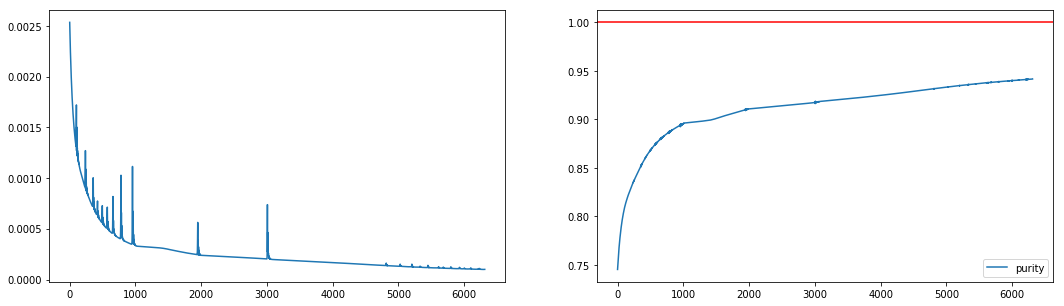

In [61]:
start = 100

plt.rcParams['figure.figsize'] = (18,5)
plt.subplot(1,2,1)
plt.plot(cost_list[start:], label="rho")
plt.subplot(1,2,2)
plt.plot(purity_list[start:], label="purity")
plt.axhline(y=purities[rho_index], color='r', linestyle='-')
plt.legend()
# plt.yscale('log')

In [ ]:
pred_dm = sess.run(reduced_dm)

In [ ]:
np.real(np.trace(pred_dm @ pred_dm))

In [ ]:
np.real(np.trace(rhos[1] @ rhos[1]))

In [ ]:
purity_fct(pred_dm)

In [41]:
purities[1]

0.9999999999999999